In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import multiprocessing
import os
import subprocess

### Impact probability code:

In [2]:
# constants for earth and sun
a0 = 1.  # semi-major axis of earth in au
m = 5.97e24  # mass of earth in kg
R = 4.259e-5  # radius of earth in au
M = 1.988e30  # mass of sun in kg
e0 = 0.01671123  # eccentricitiy of earth

compiler = 'gfortran'  # name of fortran compiler to use
# compile fortran code if it hasn't been already
subprocess.run([compiler, './Pokorny_et_al_2013/PROB_KOZAI_V001.f90', '-o', './Pokorny_et_al_2013/CODE', '-O3'])

# define function
def get_pokorny_annual_P_packed(aeiperi, a_earth=a0, e_earth=e0, R_earth=R):
    """
    Get the collisional probability using Petr Pokorny's 2013 code with a, e, i, peri packed as a tuple
    Takes in a given a, e, i and argument of pericenter of the projectile and returns the annual collisional probability

    a is in units of AU, i is in units of degrees, argument of pericenter is in degrees
    """
    a, e, i, peri = aeiperi  # unpack
    # run fortran code
    output = subprocess.run(['./Pokorny_et_al_2013/CODE', '<'], 
                            input=f'{a},{e},{i},{peri}\n{a_earth}\n{e_earth}'.encode('utf-8'), 
                            capture_output=True)
    # print(output)
    col_prob = np.float64(output.stdout.decode('utf-8').split()[-1]) * (R_earth ** 2)
    return col_prob

#### NEOPOP:

Compute the proportion of Atiras, Atens, Apollos and Amors when generating fictitious NEO data using NEOPOP:

In [3]:
telescopic_dm_neos = pd.read_csv('telescopic_decameter_neos.csv')
# get a, q, Q
telescopic_dm_as = telescopic_dm_neos.a
telescopic_dm_qs = telescopic_dm_as * (1. - telescopic_dm_neos.e)
telescopic_dm_Qs = telescopic_dm_as * (1. + telescopic_dm_neos.e)
# compute number of atiras, atens, apollos and amors for the proportion of fictitious NEOs
n_atiras = np.sum(telescopic_dm_Qs < 0.983)  # atiras have Q < 0.983 (entirely inside Earth's orbit)
n_atens = np.sum((telescopic_dm_Qs > 0.983) & (telescopic_dm_as < 1.0))  # atens have Q > 0.983, a < 1.0 (cross Earth's orbit with less than 1 AU SMA
n_apollos = np.sum((telescopic_dm_qs < 1.017) & (telescopic_dm_as > 1.0))  # apollos have q < 1.017, a > 1.0 (cross Earth's orbit with more than 1 AU SMA
n_amors = np.sum(telescopic_dm_qs > 1.017)  # amors have q > 1.017 (entirely outside Earth's orbit)

n_atiras, n_atens, n_apollos, n_amors, len(telescopic_dm_neos)

(0, 123, 152, 20, 295)

Read `.csv` of fictitious NEO data generated using NEOPOP:

In [4]:
fictitious_neos = pd.read_fwf('neopop_ANA.res', skiprows=91, header=None).dropna()
fictitious_neos.columns = [['num', 'type', 'er', 'sma', 'phd', 'ahd', 
                            'ecc', 'inc', 'raan', 'aop', 'mano', 'h', 
                            'moid', 'collprob', 'diameter', 'sun dist', 'earth idst', 
                            'epoch', 'albedo', 'caa epoch', 'caa dist', 
                            'x', 'y', 'z']]
# get the a, e, i and agrument of pericenter
fictitious_aeiperis_raw = np.array(fictitious_neos[['sma', 'ecc', 'inc', 'aop']], dtype=np.float64)  # inc, peri already in degrees
fictitious_qs_raw = np.array(fictitious_neos.phd, dtype=np.float64).flatten()
# remove objects with q > 1.017 since these cannot collide with Earth at all
q_mask = fictitious_qs_raw < 1.017
fictitious_aeiperis = fictitious_aeiperis_raw[q_mask]
fictitious_qs_raw = fictitious_qs_raw[q_mask]

Optional: Compute and save the impact probabilities for these fictitious NEOs:

In [5]:
# pool = multiprocessing.Pool()
# # compute probabilities
# fictitious_pts = np.array(list(tqdm(pool.imap(get_pokorny_annual_P_packed, fictitious_aeiperis), total=len(fictitious_aeiperis))))
# # close and join
# pool.close()
# pool.join()
# # save if necessary
# np.save('fictitious_pts.npy', fictitious_pts)

Optional: Load the computed fictitious impact probabilities and also remove 0s and nans:

In [6]:
fictitious_pts_raw = np.load('fictitious_pts.npy')
# remove 0s and nans
nan_zero_mask = (fictitious_pts_raw != 0.) & ~np.isnan(fictitious_pts_raw) 
# apply mask
fictitious_pts = fictitious_pts_raw[nan_zero_mask]
fictitious_qs = fictitious_qs_raw[nan_zero_mask]

#### NEOMOD:

Generate NEOMOD objects

In [7]:
# compile the NEOMOD2 and 3 models
neomod2_filename = './NEOMOD2_CODE'
neomod3_filename = './NEOMOD3_CODE'
subprocess.run([compiler, './neomod2_simulator.f', '-o', neomod2_filename, '-O3'])
subprocess.run([compiler, './neomod3_simulator.f', '-o', neomod3_filename, '-O3'])

# generate debiased steady-state orbital distribution for both
H_min = 26.5  # minimum H magnitude NEOMOD 2
H_max = 28.  # maximum H magniutde NEOMOD 2
size_min = 0.0079  # minimum size NEOMOD 3, km
size_max = 0.016  # maximum size NEOMOD 3, km
n_objs = 10000  # number of objects to generate
seed = -50202002  # seed to use

# generate output for neomod2 and 3
neomod2_output = np.array(subprocess.run([neomod2_filename, '<'], 
                                input=f'input_neomod2.dat\n{seed}\n{n_objs}\n{H_min} {H_max}'.encode('utf-8'), 
                                capture_output=True).stdout.decode('utf-8').split(), dtype=np.float64).reshape(n_objs, 4)  # 4 parameters
neomod3_output = np.array(subprocess.run([neomod3_filename, '<'], 
                                input=f'input_neomod3.dat\n{seed}\n{n_objs}\n{size_min} {size_max}'.encode('utf-8'), 
                                capture_output=True).stdout.decode('utf-8').split(), dtype=np.float64).reshape(n_objs, 6)  # 6 parameters

Optional: Now compute the impact probability of all of these objects, randomly drawing argument of pericenter between $0$ and $360$ degrees, and save:

Neomod 2 returns h, a, e, i

Neomod 3 returns h, a, e, i, size, albedo

In [8]:
# unpack values if needed later
neomod2_h, neomod2_a, neomod2_e, neomod2_i = neomod2_output.T
neomod3_h, neomod3_a, neomod3_e, neomod3_i, neomod3_size, neomod3_alb = neomod3_output.T

# # generate random arguments of pericenter
# random_peris = np.random.uniform(low=0., high=360., size=n_objs)  # pokorny annual P takes in degrees
# # compute impact probabilities
# neomod2_aeiperis = np.c_[neomod2_a, neomod2_e, neomod2_i, random_peris]
# neomod3_aeiperis = np.c_[neomod3_a, neomod3_e, neomod3_i, random_peris]
# # multiprocess, computing for neomod2 and 3
# pool = multiprocessing.Pool()
# neomod2_pts = np.array(list(tqdm(pool.imap(get_pokorny_annual_P_packed, neomod2_aeiperis), total = len(neomod2_aeiperis))))
# neomod3_pts = np.array(list(tqdm(pool.imap(get_pokorny_annual_P_packed, neomod3_aeiperis), total = len(neomod3_aeiperis))))
# # join and close
# pool.close()
# pool.join()
# # save
# np.save('neomod2_pts.npy', neomod2_pts)
# np.save('neomod3_pts.npy', neomod3_pts)

Optional: Load neomod impact probabilities:

In [9]:
neomod2_pts = np.load('neomod2_pts.npy')
neomod3_pts = np.load('neomod3_pts.npy')

#### Telescopic:

Compute impact probabilities of telescopically observed NEOs:

In [10]:
telescopic_aeiperis = np.array(telescopic_dm_neos[['a', 'e', 'i', 'w']])
pool = multiprocessing.Pool()
# compute probabilities
telescopic_pts = np.array(list(tqdm(pool.imap(get_pokorny_annual_P_packed, telescopic_aeiperis), total = len(telescopic_aeiperis))))
# close and join
pool.close()
pool.join()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 295/295 [00:07<00:00, 41.64it/s]


#### Decameter nominal and clones:

In [11]:
orb_param_array_all_events = np.load('orb_params_all_events_mc.npy')  # get the orbital parameters for the clones
orb_param_array_true = np.load('true_impactor_aeis.npy')  # and for the true 14 impactors
orb_param_variables = ['a', 'e', 'i', 'peri', 'node', 'M']  

# get orbital param variables from the numpy files
impactor_as, impactor_es, impactor_is, impactor_peris, impactor_nodes, impactor_Ms = orb_param_array_all_events.T
true_as, true_es, true_is, true_peris, true_nodes, true_Ms = orb_param_array_true.T

# compute impact probabilities for nominal
# and load preexisting probabilities generated in the tidal_disruption notebook:
true_pts = np.array([get_pokorny_annual_P_packed(aeiperi) for aeiperi in zip(true_as, true_es, true_is, true_peris)])
impactor_pts = np.load('impactor_pp_pts.npy')

#### CNEOS nominal:

In [12]:
# we define decameter impactors to be between 7.5 and 25 meters in diameter
# range of sizes (diameter in meters) we consider to be in the decameter regime
decameter_lb = 7.5  # lower bound
decameter_ub = 25.  # upper bound

# read file containing all impactors, no need to define columns since pandas reads this fine
all_impactors = pd.read_csv('../JPL-website-Oct19-2022-ORBITS-radiants-wspeeds-decameter-impactors-GOOD (1)_EDITED.csv', header='infer')
# filtering to only include those of decameter size (diameter is within some size range)
decameter_impactors = all_impactors.loc[(decameter_lb < all_impactors['Diameter (rho = 1500 kgm-3)']) & 
                                        (all_impactors['Diameter (rho = 1500 kgm-3)'] < decameter_ub)]

# read in cneos fireballs, dropping row if any of time, latitude, longitude, altitude, vx, vy or vz are nan
cneos_fireballs_raw = pd.read_csv('cneos_fireball_data.csv').dropna(subset=['Peak Brightness Date/Time (UT)', 
                                                                            'Latitude (deg.)', 'Longitude (deg.)', 
                                                                            'Altitude (km)', 'vx', 'vy', 'vz']).reset_index(drop=True)
# rtd is constant
rtd = np.pi/180  # rad/deg
# get time, converting to the format used by pylig: '%Y%m%d-%H%M%S.%f'
cneos_t = pd.to_datetime(cneos_fireballs_raw['Peak Brightness Date/Time (UT)'], format='mixed').dt.strftime('%Y%m%d-%H%M%S.%f')
# get elevation
cneos_elevation = cneos_fireballs_raw['Altitude (km)']

# get x, y, z velocities, dropping nans
cneos_vx, cneos_vy, cneos_vz = cneos_fireballs_raw.vx, cneos_fireballs_raw.vy, cneos_fireballs_raw.vz
# convert to numerical long, lat, dropping nans
cneos_latitude = (cneos_fireballs_raw['Latitude (deg.)'].str[:-1].astype(float) * (2 * (cneos_fireballs_raw['Latitude (deg.)'].str[-1:] == 'N') - 1))
cneos_longitude = (cneos_fireballs_raw['Longitude (deg.)'].str[:-1].astype(float) * (2 * (cneos_fireballs_raw['Longitude (deg.)'].str[-1:] == 'E') - 1))

# cneos_vx, cneos_vy, cneos_vz = -10.8, 1.2, -12.8
# cneos_latitude = 59.8
# cneos_longitude = 16.8

# should get 242.771 azim, 16.6202 zen, 16.7905 speed

# get vn, ve, vd from vx, vy, vz and lat, long
cneos_vn = -cneos_vx * np.sin(cneos_latitude * rtd) * np.cos(cneos_longitude * rtd) - cneos_vy * np.sin(cneos_longitude * rtd) * np.sin(cneos_latitude * rtd) + cneos_vz * np.cos(cneos_latitude * rtd)
cneos_ve = -cneos_vx * np.sin(cneos_longitude * rtd) + cneos_vy * np.cos(cneos_longitude * rtd)
cneos_vd = -cneos_vx * np.cos(cneos_latitude * rtd) * np.cos(cneos_longitude * rtd) - cneos_vy * np.cos(cneos_latitude * rtd) * np.sin(cneos_longitude * rtd) - cneos_vz * np.sin(cneos_latitude * rtd)
# get azimuth and zenith
cneos_azim = np.arctan2(cneos_ve, cneos_vn)/rtd + 180.  # NOTE that arctan2 in excel is (x, y) but arctan2 in numpy is (y, x)!
cneos_zen = np.arctan(np.sqrt(cneos_vn ** 2 + cneos_ve ** 2)/cneos_vd)/rtd
# get total velocity
cneos_v = np.sqrt(cneos_vx ** 2 + cneos_vy ** 2 + cneos_vz ** 2)

# filter for events with unphysical zeniths
zen_mask = (0. < cneos_zen) & (cneos_zen < 90.)  # create mask for zenith between 0 and 90 degrees
# filtering
cneos_fireballs_raw = cneos_fireballs_raw[zen_mask]

# convert both to the same datetime format
decameter_impactors['converted_time'] = pd.to_datetime(decameter_impactors['Time'], format='mixed', dayfirst=True).dt.strftime('%Y-%m-%d')
cneos_fireballs_raw['converted_time'] = pd.to_datetime(cneos_fireballs_raw['Peak Brightness Date/Time (UT)'], format='mixed', dayfirst=True).dt.strftime('%Y-%m-%d')

# all decameter events except the February 1, 1994, September 3, 2004 and January 14, 1999 fireballs are in the cneos file as well
# so these events do NOT need to be excised because they have already been filtered from the CNEOS file (due to having missing data in CNEOS),
# but we still have data for these events from other sources

# so we create an array of indices for all the overlapping decameter objects in the CNEOS data
decameter_indices = np.array(cneos_fireballs_raw.converted_time[cneos_fireballs_raw.converted_time.isin(decameter_impactors.converted_time)].index).astype(int)

# and then filter them out of the CNEOS data
cneos_v_filtered = np.delete(cneos_v[zen_mask], decameter_indices)
cneos_t_filtered = np.delete(cneos_t[zen_mask], decameter_indices)
cneos_latitude_filtered = np.delete(cneos_latitude[zen_mask], decameter_indices)
cneos_longitude_filtered = np.delete(cneos_longitude[zen_mask], decameter_indices)
cneos_elevation_filtered = np.delete(cneos_elevation[zen_mask], decameter_indices)
cneos_zen_filtered = np.delete(cneos_zen[zen_mask], decameter_indices)
cneos_azim_filtered = np.delete(cneos_azim[zen_mask], decameter_indices)
# combine
cneos_params_filtered = np.c_[cneos_v_filtered, cneos_t_filtered, cneos_latitude_filtered, cneos_longitude_filtered, cneos_elevation_filtered, cneos_zen_filtered, cneos_azim_filtered]

/tmp/ipykernel_150279/3919203949.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decameter_impactors['converted_time'] = pd.to_datetime(decameter_impactors['Time'], format='mixed', dayfirst=True).dt.strftime('%Y-%m-%d')


Optional: Compute nominal orbits of all $297$ physical USG impactors and save:

In [13]:
# # get aeis
# def get_orbit(event):
#     """
#     Get orbit from state vector using wmpl/pylig
#     """
#     v, t, a, o, e, zen, azim = event  # since it should be in that order in impactor_state_vectors table
#     # zenith is 90 - alt
#     alt = 90 - zen
#     # run wmpl
#     output = subprocess.run(['python3', '-m', 'wmpl.Trajectory.Orbit', '-v', f'{v}', '-t', f'{t}', '-a', f'{a}', 
#                              '-o', f'{o}', '-e', f'{e}', '--azim', f'{azim}', '--alt', f'{alt}', 
#                              '--vrotcorr', '--statfixed'], capture_output=True)
#     # get orbital parameters from the output in the order of orb_param_variables
#     # print(output)
#     parsed_output = np.array([np.float64(string) for param in [elem for elem in 
#                                                               list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) 
#                                                               if elem.startswith(tuple(orb_param_variables))] 
#                              for string in param.split() if string.lstrip('-').replace('.', '').isdigit() or string =='nan'])
#     # return output if it works, otherwise return nans to say that wmpl failed
#     if parsed_output.size:
#         return parsed_output
#     else:
#         return np.repeat(np.nan, len(orb_param_variables))

# # now multiprocess
# pool = multiprocessing.Pool(16)  # 16 threads seems to work better since it crashes on saturn with too many threads??
# # multiprocess
# cneos_aeis = np.array(list(tqdm(pool.imap(get_orbit, cneos_params_filtered))))
# # close and join pool
# pool.close()
# pool.join()

# # save
# np.save('cneos_aeis.npy', cneos_aeis)

Optional: Load nominal orbits of all $297$ physical USG impactors and filter them by tisserand/Borovicka asteroidal criteria:

In [14]:
cneos_aeis = np.load('cneos_aeis.npy')

# get a, e, i, q for CNEOS fireballs and flatten
cneos_as_raw, cneos_es_raw, cneos_is_raw, cneos_peris_raw, cneos_nodes_raw, cneos_Ms_raw = cneos_aeis.T
cneos_qs_raw = (cneos_as_raw * (1. - cneos_es_raw)).T
cneos_Qs_raw = cneos_as_raw * (1. + cneos_es_raw)

# filter
sma_jupiter = 5.20336301
tisserand_cutoff = 'borovicka'  # either a number to filter by tisserand parameter or 'borovicka' to use the borovicka criteria
# tisserand_cutoff = 3.0
# compute tj
cneos_tjs_raw = (sma_jupiter/cneos_as_raw) + 2. * np.cos(np.deg2rad(cneos_is_raw)) * np.sqrt((cneos_as_raw/sma_jupiter) * (1. - cneos_es_raw ** 2))
# mask based on criteria of borovicka et al 2022 or based on tj and Q < 4.9 AU
cneos_tisserand_mask = (cneos_Qs_raw.T < 4.9) | (cneos_is_raw.T > 40.) | (cneos_es_raw.T > 0.9) if tisserand_cutoff == 'borovicka' else (cneos_tjs_raw.T > tisserand_cutoff) | (cneos_Qs_raw.T < 4.9)
# filter by the tisserand mask, no need to filter by sporadics since these are all sporadic
cneos_aeis_filtered = cneos_aeis[cneos_tisserand_mask]
# cneos_aeis_filtered = cneos_aeis_filtered[~np.isnan(cneos_aeis_filtered)]
cneos_aeis_filtered = cneos_aeis_filtered[np.all(~np.isnan(cneos_aeis_filtered), axis=1)]

Compute the nominal impact probability:

In [15]:
# compute nominal impact probabilities
cneos_nom_aeiperis = cneos_aeis_filtered[:,:4]  # since it's a, e, i, peri, node, M in that order take the first 4
# multiprocess
pool = multiprocessing.Pool()
cneos_nom_pts = np.array(list(tqdm(pool.imap(get_pokorny_annual_P_packed, cneos_nom_aeiperis), total = len(cneos_nom_aeiperis))))
# join and close
pool.close()
pool.join()
# save
np.save('cneos_nom_pts.npy', cneos_nom_pts)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [00:07<00:00, 36.00it/s]


**Note: the number of nominal CNEOS objects and the number of clones doesn't match (264 - 249)**

### CNEOS clones:

In [16]:
n_cneos_events = 249  # number of cneos events after borovicka filtering
n_monte_carlo_samples = 1000

# load preexisting probabilities generated in the tidal_disruption notebook, this should have the same length as the nominal:
cneos_pts_raw = np.load('cneos_pp_pts.npy')

cneos_pts_reshaped = cneos_pts_raw.reshape(249, n_monte_carlo_samples)# [cneos_tisserand_mask]

cneos_pts_nonnan = list()
cneos_qs_nonnan = list()

for i in range(len(cneos_pts_reshaped)):
    non_nan_mask_cneos = ~np.isnan(cneos_pts_reshaped[i]) # mask of non nan impact probabilities for that cneos
    # filter out nan impact probabilities for that cneos
    cneos_pts_nonnan_i = cneos_pts_reshaped[i][non_nan_mask_cneos]
    # filter out 0 impact probabilities too since pokorny returns a bunch of those
    impact_cneos_prob_mask_i = cneos_pts_nonnan_i > 0.
    cneos_pts_nonnan_i = cneos_pts_nonnan_i[impact_cneos_prob_mask_i]
    # and append to the list
    cneos_pts_nonnan.append(cneos_pts_nonnan_i)

# convert to array
cneos_pts = np.array([cneos_pt for cneos_pt_list in cneos_pts_nonnan for cneos_pt in cneos_pt_list])

#### EFN and EMCCD nominal (no clones):

Load EFN and EMCCD data for filtering:

In [17]:
# Read in EFN fireballs

efn_fireballs_raw = pd.read_fwf('catalog.dat', header=None).drop(columns=[81, 85]) # drop column 81 as well since it's having trouble reading phaethon
efn_fireballs_raw.columns = ['code', 'obs_date', 'obs_time', 'e_obs_time', 'jd', 
                        'lsun', 'lam-beg', 'phi-beg', 'h-beg', 'lam-end', 
                        'phi-end', 'h-end', 'lam-avg', 'phi-avg', 'h-avg', 
                        'lam-max', 'phi-max', 'h-max', 'length', 'dur', 
                        'azim', 'zendis', 'radeg', 'e_radeg', 'dedeg', 
                        'e_dedeg', 'vinf', 'e_vinf', 'vmax', 'vter', 
                        'hvter', 'rageo', 'e_rageo', 'degeo', 'e_degeo', 
                        'lgeo-lsun', 'bgeo', 'vgeo', 'e_vgeo', 'lhel', 
                        'e_lhel', 'bhel', 'e_bhel', 'vhel', 'e_vhel', 
                        'ax', 'e_ax', 'ecc', 'e_ecc', 'perih', 
                        'e_perih', 'aph', 'e_aph', 'inc', 'e_inc', 
                        'omg', 'e_omg', 'nod', 'e_nod', 'lper', 
                        'e_lper', 'tyear', 'tmonth', 'tday', 'e_tday', 
                        'per', 'e_per', 'tiss', 'e_tiss', 'mag', 
                        'energy', 'mass', 'termass', 'pe', 'type', 
                        'pres', 'hpres', 'pf', 'pf-class', 'shower', 
                        'object', 'ncam', 'mindist', 'spectrum']

# filter out rows with e > 0.98 or q less than radius of sun
r_sun=0.00465
efn_fireballs_all = efn_fireballs_raw[~(efn_fireballs_raw.ecc > 0.98) | (efn_fireballs_raw.perih < r_sun)]

# Read in EMCCD data

# import kb_and_kc_calc
# emccd_meteors = kb_and_kc_calc.extract_from_table()
emccd_meteors_raw = pd.read_json('solution_table.json')


# generate sporadic masks
efn_sporadic_mask = efn_fireballs_all.shower.isna()  # coompute this since we also need to select only the sporadic clones as well
efn_fireballs_sporadic = efn_fireballs_all[efn_sporadic_mask]  # not associated with a shower

emccd_sporadic_mask = emccd_meteors_raw.shower_no == -1  # compute this since we also need to filter impact probabilities by this
emccd_meteors_sporadic = emccd_meteors_raw[emccd_sporadic_mask]  # not associated with a shower

# for EMCCD fireballs
emccd_as_raw, emccd_es_raw, emccd_is_raw, emccd_omegas_raw, emccd_nodes_raw, emccd_ms_raw, emccd_qs_raw = np.array(emccd_meteors_sporadic[['a', 'e', 'i', 'omega', 'asc_node', 'mean_anomaly', 'q']]).T

orb_param_array_efn_raw = np.load('orb_params_efn_mc.npy')
efn_as_raw, efn_es_raw, efn_is_raw, efn_peris_raw, efn_nodes_raw, _ = orb_param_array_efn_raw[efn_sporadic_mask].T

sma_jupiter = 5.20336301
tisserand_cutoff = 'borovicka'  # either a number to filter by tisserand parameter or 'borovicka' to use the borovicka criteria
# tisserand_cutoff = 3.0

#### EFN:

efn_Qs_raw = efn_as_raw * (1. + (efn_es_raw))
# compute tj
efn_tjs_raw = (sma_jupiter/efn_as_raw) + 2. * np.cos(np.deg2rad(efn_is_raw)) * np.sqrt((efn_as_raw/sma_jupiter) * (1. - efn_es_raw ** 2))
# mask based on criteria of borovicka et al 2022 or based on tj and Q < 4.9 AU
efn_tisserand_mask = (efn_Qs_raw.T[:, 0] < 4.9) | (efn_is_raw.T[:, 0] > 40.) | (efn_es_raw.T[:, 0] > 0.9) if tisserand_cutoff == 'borovicka' else (efn_tjs_raw.T[:, 0] > tisserand_cutoff) | (efn_Qs_raw.T[:, 0] < 4.9)
# filter by the mask
orb_param_array_efn = orb_param_array_efn_raw[efn_sporadic_mask][efn_tisserand_mask]
efn_as, efn_es, efn_is, efn_peris, efn_nodes, _ = orb_param_array_efn.T
# define efn qs
efn_qs = (efn_as * (1. - efn_es)).T# .reshape(-1)

#### EMCCD:

emccd_Qs_raw = emccd_as_raw * (1. + (emccd_es_raw))
emccd_tjs_raw = (sma_jupiter/emccd_as_raw) + 2. * np.cos(np.deg2rad(emccd_is_raw)) * np.sqrt((emccd_as_raw/sma_jupiter) * (1. - emccd_es_raw ** 2))
# mask based on criteria of borovicka et al 2022
emccd_tisserand_mask = (emccd_Qs_raw.T < 4.9) | (emccd_is_raw.T > 40.) | (emccd_es_raw.T > 0.9) if tisserand_cutoff == 'borovicka' else (emccd_tjs_raw > tisserand_cutoff) | (emccd_Qs_raw.T < 4.9)
# filter by the mask
emccd_meteors = emccd_meteors_sporadic[emccd_tisserand_mask]
emccd_as, emccd_es, emccd_is, emccd_omegas, emccd_nodes, emccd_ms, emccd_qs = np.array(emccd_meteors[['a', 'e', 'i', 'omega', 'asc_node', 'mean_anomaly', 'q']]).T

In [18]:
# load preexisting probabilities generated in the tidal_disruption notebook:
emccd_pts_raw = np.load('emccd_pp_pts.npy')
efn_pts_raw = np.load('efn_pp_pts.npy')

n_monte_carlo_samples = 1000

efn_pts_unfiltered = efn_pts_raw.reshape(len(orb_param_array_efn_raw), n_monte_carlo_samples)[efn_sporadic_mask][efn_tisserand_mask]
emccd_pts_unfiltered = emccd_pts_raw[emccd_sporadic_mask][emccd_tisserand_mask]

efn_pts = list()
for i in range(len(efn_pts_unfiltered)):
    non_nan_mask_efn = ~np.isnan(efn_pts_unfiltered[i])  # mask of all non-nan impact probabilities for that efn
    # filte rout nan impact probabilities for that efn
    efn_pts_nonnan_i = efn_pts_unfiltered[i][non_nan_mask_efn]
    # filter out 0 impact probabilities too since pokorny returns a bunch of those
    impact_efn_prob_mask_i = efn_pts_nonnan_i > 0.
    efn_pts_nonnan_i = efn_pts_nonnan_i[impact_efn_prob_mask_i]
    # and append to the list
    efn_pts.append(efn_pts_nonnan_i)

# convert to array
efn_pts = np.array([efn_pt for efn_pts_list in efn_pts for efn_pt in efn_pts_list])

emccd_non_nan_mask = ~np.isnan(emccd_pts_unfiltered)
emccd_pts_nonnan = emccd_pts_unfiltered[emccd_non_nan_mask]

impact_prob_mask_emccd = emccd_pts_nonnan > 0.
emccd_pts = emccd_pts_nonnan[impact_prob_mask_emccd] # already array

#### Removing impactors with apses near $1$ AU:

For target orbit with $a_\mathrm{circ} = 1$ AU, we remove objects with $a_\mathrm{circ} - q = 5 \times 10^{-5}$ AU to $7.5 \times 10^{-5}$ AU based on Fig. 10 of V&P 2012:

In [19]:
# apses of earth
q0 = a0 * (1. - e0)
Q0 = a0 * (1. + e0)
# neomod q and Qs
neomod3_q = neomod3_a * (1. - neomod3_e)
neomod3_Q = neomod3_a * (1. + neomod3_e)
# set threshold rho
rho = 5e-5  # AU
# generate masks
# only objects whose q AND Q values are both not within Earth's orbital range are used here
# also filter out object that cannot collide with the Earth due to peri/ap
rho_q_mask = ((q0 - rho) > neomod3_q)#  | (neomod3_q > (Q0 + rho))
rho_Q_mask = (neomod3_Q > (Q0 + rho))#  | ((q0 - rho) > neomod3_Q)


# filter
filtered_neomod3_pts = neomod3_pts[rho_q_mask & rho_Q_mask]
filtered_neomod3_q = neomod3_q[rho_q_mask & rho_Q_mask]
filtered_neomod3_Q = neomod3_Q[rho_q_mask & rho_Q_mask]
filtered_neomod3_a = neomod3_a[rho_q_mask & rho_Q_mask]
filtered_neomod3_e = neomod3_e[rho_q_mask & rho_Q_mask]
filtered_neomod3_i = neomod3_i[rho_q_mask & rho_Q_mask]

### Plotting:

Filtered NEOMOD3 impact probabilities:

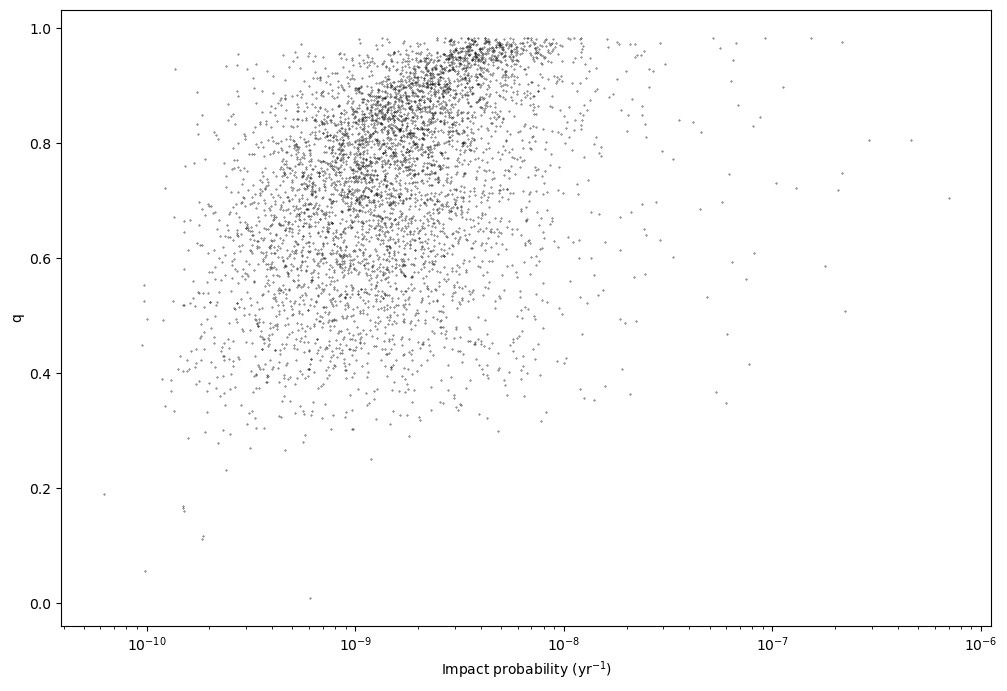

In [20]:
plt.figure(figsize = (12, 8))
plt.scatter(filtered_neomod3_pts, filtered_neomod3_q, c='k', s=0.1, alpha = 0.9)
plt.xlabel(r'Impact probability (yr$^{-1}$)'), plt.ylabel ('q')
plt.xscale('log')

IP CDF plot:

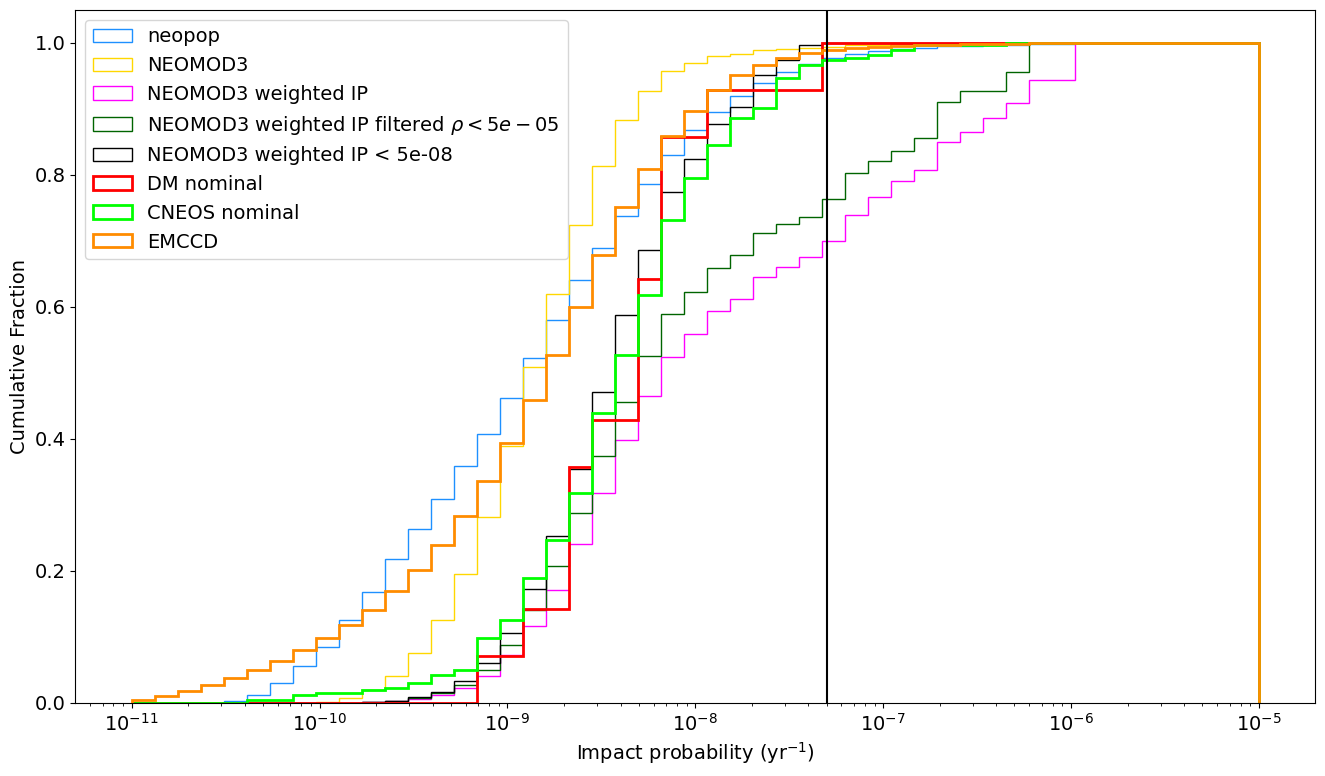

In [21]:
logbins = np.logspace(-11, -5, 50)  # plot from 10^-11 to 10^-5 yr^-1 impact probability

# truncation threshold for cutting the neopop/neomod2/3 models
truncation_threshold = 5e-8
# neopop
truncation_neopop_mask = fictitious_pts < truncation_threshold
truncated_neopop_pts = fictitious_pts[truncation_neopop_mask]
# neomod2
truncation_neomod2_mask = neomod2_pts < truncation_threshold
truncated_neomod2_pts = neomod2_pts[truncation_neomod2_mask]
# neomod3
truncation_neomod3_mask = neomod3_pts < truncation_threshold
truncated_neomod3_pts = neomod3_pts[truncation_neomod3_mask]

plt.rc('font', size=14)
plt.figure(figsize = (16, 9))
# NEOPOP
plt.hist(fictitious_pts, weights=None, bins = logbins, density=True, cumulative=True, histtype='step', color = 'dodgerblue', label = 'neopop')
# plt.hist(fictitious_pts, weights=fictitious_pts, bins = logbins, density=True, cumulative=True, color = 'darkorange', histtype='step', label = 'neopop IP weighted')
# plt.hist(truncated_neopop_pts, weights=truncated_neopop_pts, bins=logbins, density=True, cumulative=True, color = 'purple', histtype='step', label = f'IP < {truncation_threshold} neopop weighted')
# NEOMOD2
# plt.hist(neomod2_pts, weights=None, bins=logbins, density=True, cumulative=True, histtype='step', color = 'brown', label = 'NEOMOD2')
# plt.hist(neomod2_pts, weights=neomod2_pts, bins=logbins, density=True, cumulative=True, histtype='step', color = 'darkblue', label = 'NEOMOD2 weighted')
# NEOMOD3
plt.hist(neomod3_pts, weights=None, bins=logbins, density=True, cumulative=True, histtype='step', color = 'gold', label = 'NEOMOD3')
plt.hist(neomod3_pts, weights=neomod3_pts, bins=logbins, density=True, cumulative=True, histtype='step', color = 'fuchsia', label = 'NEOMOD3 weighted IP')
plt.hist(filtered_neomod3_pts, weights=filtered_neomod3_pts, bins=logbins, density=True, cumulative=True, histtype='step', color = 'darkgreen', label = rf'NEOMOD3 weighted IP filtered $\rho < {rho}$')
plt.hist(truncated_neomod3_pts, weights=truncated_neomod3_pts, bins=logbins, density=True, cumulative=True, histtype='step', color = 'black', label = f'NEOMOD3 weighted IP < {truncation_threshold}')
# # Decameter
plt.hist(true_pts, weights=None, bins=logbins, density=True, cumulative=True, histtype='step', color='red', label = 'DM nominal', linewidth=2.)  # nominal
# plt.hist(impactor_pts.flatten(), weights=None, bins=logbins, density=True, cumulative=True, histtype='step', color='black', label = 'nominal DM clones')  # impactor points
# # # Telescopic
# plt.hist(telescopic_pts, weights=None, bins=logbins, density=True, cumulative=True, histtype='step', color='darkgreen', label = 'tele unweighted')
# plt.hist(telescopic_pts, weights=telescopic_pts, bins=logbins, density=True, cumulative=True, histtype='step', color='pink', label = 'tele weighted')
# # # CNEOS
plt.hist(cneos_nom_pts, weights=None, bins=logbins, density=True, cumulative=True, histtype='step', color='lime', label = 'CNEOS nominal', linewidth=2.)
# plt.hist(cneos_pts, weights=None, bins=logbins, density=True, cumulative=True, histtype='step', color='darkred', label = 'CNEOS clones')
# # # EFN
# plt.hist(efn_pts, weights=None, bins=logbins, density=True, cumulative=True, histtype='step', color = 'olive', label = 'EFN', linewidth=2.)
# # # EMCCD
plt.hist(emccd_pts, weights=None, bins=logbins, density=True, cumulative=True, histtype='step', color = 'darkorange', label = 'EMCCD', linewidth=2.)
# housekeeping
plt.xscale('log')
plt.xlabel(r'Impact probability (yr$^{-1}$)'), plt.ylabel('Cumulative Fraction')
# plt.ylim(bottom=0.9, top=1.0)
plt.axvline(truncation_threshold, color='k')
plt.legend()
# plt.savefig('dda_talk_plots/impact_probability_cdfs.png')
# plt.savefig('dda_talk_plots/impact_probability_cdfs_plus_emccd.png')


Difference between the truncated NEOMOD3 and the CNEOS nominal:

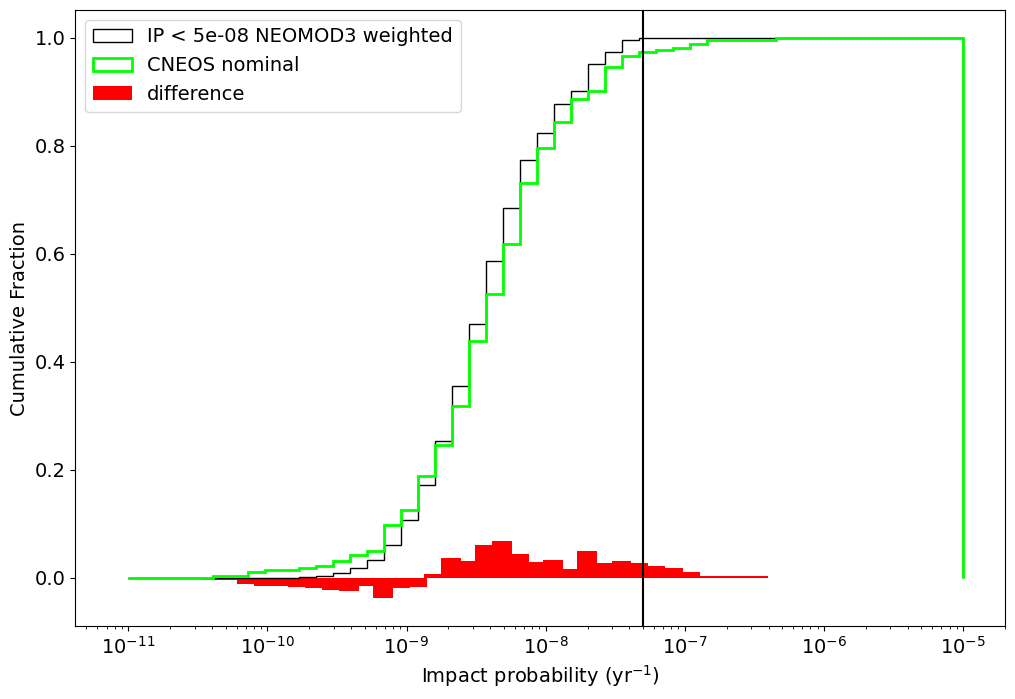

In [22]:
plt.figure(figsize = (12, 8))
neomod3_bins, neomod3_edges, _ = plt.hist(truncated_neomod3_pts, weights=truncated_neomod3_pts, bins=logbins, density=True, cumulative=True, histtype='step', color = 'black', label = f'IP < {truncation_threshold} NEOMOD3 weighted')
cneos_bins, cneos_edges, _ = plt.hist(cneos_nom_pts, weights=None, bins=logbins, density=True, cumulative=True, histtype='step', color='lime', label = 'CNEOS nominal', linewidth=2.)
plt.bar(cneos_edges[:-1], neomod3_bins - cneos_bins, width=np.diff(cneos_edges), linestyle = 'solid', color = 'red', fill=True, label = 'difference')
plt.xscale('log')
plt.xlabel(r'Impact probability (yr$^{-1}$)'), plt.ylabel('Cumulative Fraction')
plt.axvline(truncation_threshold, color='k')
plt.legend()
plt.savefig('dda_talk_plots/neomod3_cneos_nominal_difference.png')

Taking the highest impact probability objects from NEOMOD and CNEOS:

In [23]:
high_ip_threshold = 5.e-8  # threshold to be considered "high impact probability"
# high impact probability
high_ip_neomod3_pts = neomod3_pts[neomod3_pts > high_ip_threshold]
high_ip_cneos_nom_pts = cneos_nom_pts[cneos_nom_pts > high_ip_threshold]
# orbits
high_ip_neomod3_output = neomod3_output[neomod3_pts > high_ip_threshold]
high_ip_cneos_nom_aeiperis = cneos_nom_aeiperis[cneos_nom_pts > high_ip_threshold]

Scatter on a vs. e, a vs. i plots:

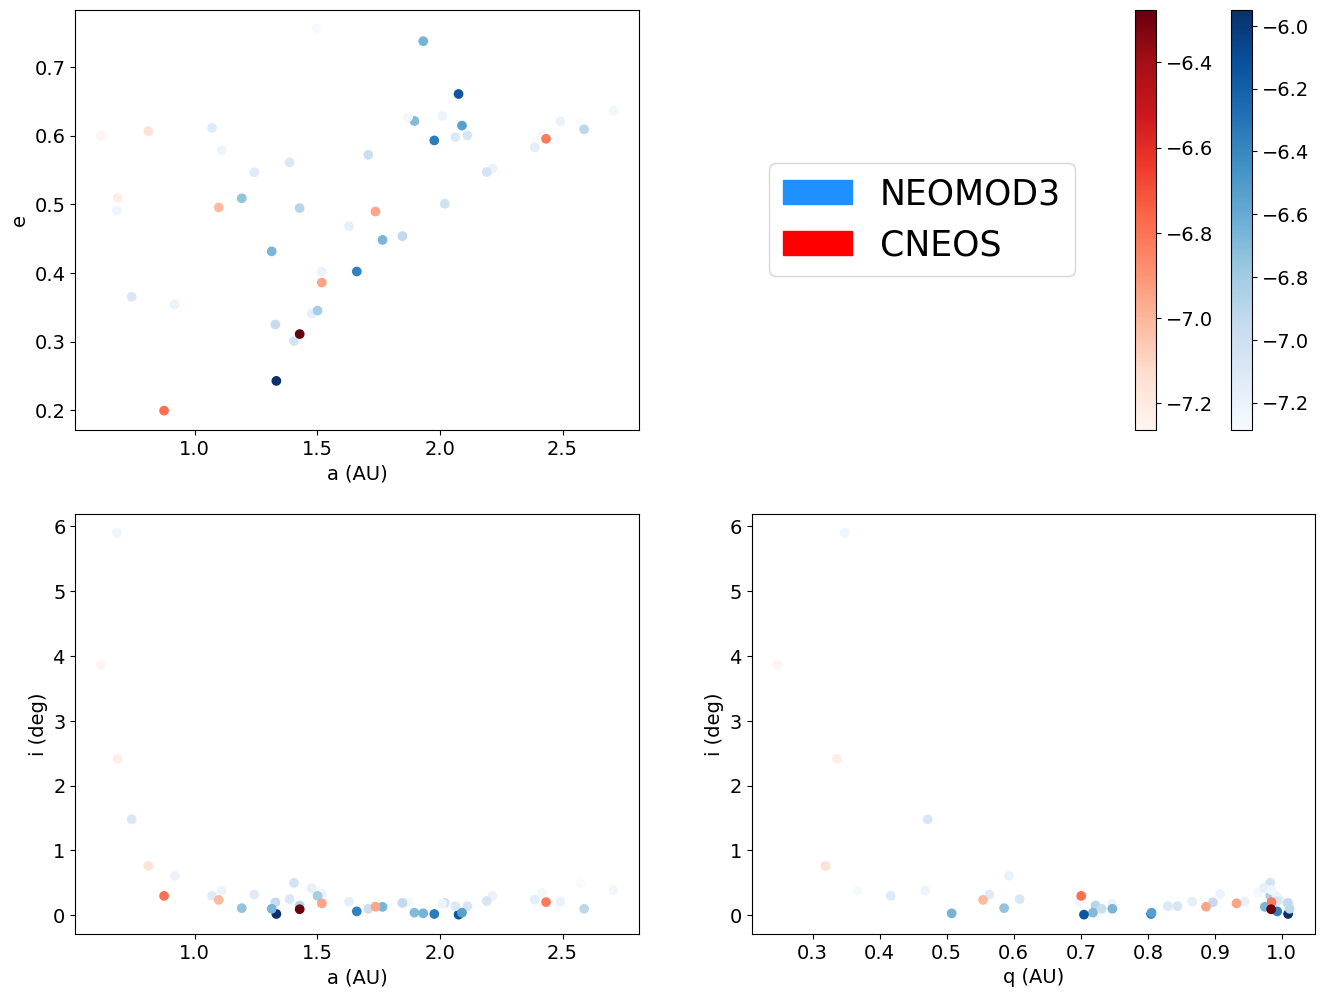

In [24]:
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# NEOMOD3 is h, a, e, i, size, albedo
# cneos is a, e, i, peri
fig, [[tl, tr], [bl, br]] = plt.subplots(nrows=2, ncols=2, figsize = (16, 12))
# a vs. e
blues = tl.scatter(high_ip_neomod3_output[:, 1], high_ip_neomod3_output[:, 2], c=np.log10(high_ip_neomod3_pts), cmap='Blues')
reds = tl.scatter(high_ip_cneos_nom_aeiperis[:, 0], high_ip_cneos_nom_aeiperis[:, 1], c=np.log10(high_ip_cneos_nom_pts), cmap='Reds')
tl.set_xlabel('a (AU)'), tl.set_ylabel('e')
# a vs. i
bl.scatter(high_ip_neomod3_output[:, 1], high_ip_neomod3_output[:, 3], c=np.log10(high_ip_neomod3_pts), cmap='Blues')
bl.scatter(high_ip_cneos_nom_aeiperis[:, 0], high_ip_cneos_nom_aeiperis[:, 2], c=np.log10(high_ip_cneos_nom_pts), cmap='Reds')
bl.set_xlabel('a (AU)'), bl.set_ylabel('i (deg)')
# q vs. i
br.scatter(high_ip_neomod3_output[:, 1] * (1. -  high_ip_neomod3_output[:, 2]), high_ip_neomod3_output[:, 3], c=np.log10(high_ip_neomod3_pts), cmap='Blues')
br.scatter(high_ip_cneos_nom_aeiperis[:, 0] * (1. - high_ip_cneos_nom_aeiperis[:, 1]), high_ip_cneos_nom_aeiperis[:, 2], c=np.log10(high_ip_cneos_nom_pts), cmap='Reds')
br.set_xlabel('q (AU)'), br.set_ylabel('i (deg)')
# legend
# legend colours
blue_patch = mpatches.Patch(color='dodgerblue', label='NEOMOD3')
orange_patch = mpatches.Patch(color='red', label='CNEOS')
# plot some random data
tr.scatter(0, 0)
# clear and legend
tr.clear()  # clears the random data I plotted previously
tr.set_axis_off()  # removes the XY axes
# colorbars
red_cbar = fig.colorbar(blues, ax=tr)
blue_cbar = fig.colorbar(reds, ax=tr)
# legend
tr.legend(handles=[blue_patch, orange_patch], loc='center left', fontsize=25)